# Extract features from the dataset

In [1]:
import json
import pandas as pd
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import networkx as nx
import numpy as np

import copy
import matplotlib.pyplot as plt
##### model
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN


import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils.convert import from_networkx


%matplotlib inline



/Users/yanircohen/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# crate a list to add dataframes to
awsc_list = list()

# list of files
files_list = ['../Datasets/flaws_cloudtrail00.json']

# Load event names
category_file = open("../Utils/event_category.json")
event_categories = json.load(category_file)
category_file.close()

encoder = OneHotEncoder(handle_unknown='ignore')
label_encoder = LabelEncoder()

In [3]:
starts_with_di = {
    'CreateObject': ['request','create','copy','run','purchase','allocate','import'],
    'ModifyExistingResource': ['modify','update','set','tag','deregister','Deprecate','un','reject','register'],
    'ListResources' : ['list'],
    'Download/UploadObjects': ['getobjects','upload'],
    'GetInfo': ['describe','get','search'],
    'AssociateResources' : ['associate','put'],
    'Login' : ['assume','login','switch','renewrole','renewdelegate'],
    'RemovePermissions': ['remove'],
    'GrantPermissions': ['add','authorize']

}

contains_di = {
    'Delete': ['delet','terminate','revoke','drop','releaseaddress'] ,
    'DisableObjects': ['disabl','stop','cancel','unlink','suspend'],
    'EnableObjects': ['enabl','start','invoke','subscribe','test','complete'],
    'SensitiveInfo': ['send','accesskey','secretkey','token','invite','exportapi'],
    'Logout': ['exit'],
    'CreateObject': ['create','copy'],
    'ModifyExistingResource': ['failover','change','confirm','promote','reboot','rotate','replace','retire','detach','modify','update','set','tag','deregister','Deprecate','attach','upgrade','wipe','transfer','validate','publish'],
    'ListResources' : ['list'],
    'Download/UploadObjects': ['getobjects','upload'],
    'GetInfo': ['describe','get','view'],
    'AssociateResources' : ['associate','put'],
    'Login' : ['assume','login','renewrole','sign','forgot'],
    'Logout' : ['logout']

}

In [4]:
for file in files_list:
    with open(file, 'r', encoding='utf-8') as f:
        data = json.loads(f.read())
        
        # Append the dataframes
        awsc_list.append(pd.DataFrame.from_records(data['Records']))

In [5]:
# Merge data frames into one 
awsc = pd.concat(awsc_list).reset_index(drop=True)

In [6]:
awsc[(awsc['eventSource']=='cognito-idp.amazonaws.com')]

,userAgent,eventID,userIdentity,eventType,sourceIPAddress,eventName,eventSource,recipientAccountId,requestParameters,awsRegion,...,eventVersion,eventTime,errorMessage,errorCode,apiVersion,readOnly,resources,additionalEventData,sharedEventID,vpcEndpointId


In [7]:
users = pd.json_normalize(awsc['userIdentity']).merge(awsc[['eventTime','eventName','eventSource','awsRegion','errorCode']], left_index=True,right_index=True)

In [8]:
users['userName'] = users['userName'].fillna(users['arn']).fillna(users['invokedBy']) \
.fillna(users['invokedBy']).fillna(users['principalId']).fillna('accountId')

In [9]:
users = users[['eventTime','type','userName','eventName','eventSource','awsRegion','errorCode']]
users = users.rename(columns = {'eventTime':'timestamp','userName':'Identifier','eventSource':'TargetService','errorCode':'Error'})


In [10]:
users.head()


,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error
0,2017-02-12T19:57:06Z,Root,arn:aws:iam::811596193553:root,ListBuckets,s3.amazonaws.com,us-east-1,NaN
1,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,GetAccountPasswordPolicy,iam.amazonaws.com,us-east-1,NoSuchEntityException
2,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,GetAccountSummary,iam.amazonaws.com,us-east-1,NaN
3,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,ListAccountAliases,iam.amazonaws.com,us-east-1,NaN
4,2017-02-12T19:59:10Z,Root,arn:aws:iam::811596193553:root,ListMFADevices,iam.amazonaws.com,us-east-1,NaN


In [11]:
awsc.head()


,userAgent,eventID,userIdentity,eventType,sourceIPAddress,eventName,eventSource,recipientAccountId,requestParameters,awsRegion,...,eventVersion,eventTime,errorMessage,errorCode,apiVersion,readOnly,resources,additionalEventData,sharedEventID,vpcEndpointId
0,[S3Console/0.4],3038ebd2-c98a-4c65-9b6e-e22506292313,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,ListBuckets,s3.amazonaws.com,811596193553,None,us-east-1,...,1.04,2017-02-12T19:57:06Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,console.amazonaws.com,22a0d9b1-deea-4d39-827b-2af7050ed3f3,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,GetAccountPasswordPolicy,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,The Password Policy with domain name 811596193...,NoSuchEntityException,NaN,NaN,NaN,NaN,NaN,NaN
2,console.amazonaws.com,9facf7ca-cb76-4b19-940c-3de6803f7efb,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,GetAccountSummary,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,console.amazonaws.com,6596d3b4-7c98-40b1-867d-f317f1dbdc18,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,ListAccountAliases,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,console.amazonaws.com,9f9d038c-e5a5-443e-83d5-4cf00941d399,"{'type': 'Root', 'principalId': '811596193553'...",AwsApiCall,255.253.125.115,ListMFADevices,iam.amazonaws.com,811596193553,None,us-east-1,...,1.02,2017-02-12T19:59:10Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
li = []
def change_name(name):
    if name in event_categories:
        return event_categories[name]
    for key,value in starts_with_di.items():
        for event_name in value:
            if name.lower().startswith(event_name):
                return key
    for key,value in contains_di.items():
        for event_name in value:
            if event_name in name.lower():
                return key
    li.append(name)

users['eventName'] = users['eventName'].apply(lambda name: change_name(name))

# users['eventName'] = pd.DataFrame({'eventName':encoder.fit_transform(users[['eventName']]).toarray().tolist()},)
# users = users.join(encoder_df)
# users = users.drop('eventName', axis=1)

In [13]:
users['timestamp'] = pd.to_datetime(users['timestamp']).map(pd.Timestamp.timestamp).map(int)
users = users.sort_values('timestamp',ascending=True,ignore_index=True)

In [14]:
def get_time_df(start,end,minutes,df,col='timestamp'):
    minutes = minutes * 60
    df_list = []
    while start < end:
        cur_df = df[(df[col] >= start) & (df[col] < start+minutes)]
        if len(cur_df):
            df_list.append(df[(df[col] >= start) & (df[col] < start+minutes)])
        start+=minutes
    return df_list

In [15]:
users['Identifier'] = users['Identifier'].apply(lambda x : x if (len(x.split(":"))!=2) else x.split(":")[0])
users.nunique()

timestamp        58647
type                 5
Identifier          26
eventName           11
TargetService       49
awsRegion           15
Error               60
dtype: int64

In [16]:
# With region
# users['identity-event'] = "source-"+users['Identifier'] + "|" + users['eventName']
# users['event-region'] = users['eventName'] + "|" + users['awsRegion']
# users['region-target'] = users['awsRegion'] + "|" + "target-"+ users['TargetService']

# Without region

users['identity-event'] = "source-"+users['Identifier'] + "|" + users['eventName']
users['event-target'] = users['eventName'] + "|" + "target-"+ users['TargetService']
users = users[users['eventName'].notna()]

# print("Number of nodes")

In [17]:
users.head()

,timestamp,type,Identifier,eventName,TargetService,awsRegion,Error,identity-event,event-target
0,1486929426,Root,arn:aws:iam::811596193553:root,ListResources,s3.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|ListReso...,ListResources|target-s3.amazonaws.com
1,1486929550,Root,arn:aws:iam::811596193553:root,GetInfo,iam.amazonaws.com,us-east-1,NoSuchEntityException,source-arn:aws:iam::811596193553:root|GetInfo,GetInfo|target-iam.amazonaws.com
2,1486929550,Root,arn:aws:iam::811596193553:root,GetInfo,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|GetInfo,GetInfo|target-iam.amazonaws.com
3,1486929550,Root,arn:aws:iam::811596193553:root,ListResources,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|ListReso...,ListResources|target-iam.amazonaws.com
4,1486929550,Root,arn:aws:iam::811596193553:root,ListResources,iam.amazonaws.com,us-east-1,NaN,source-arn:aws:iam::811596193553:root|ListReso...,ListResources|target-iam.amazonaws.com


In [18]:
users['Identifier'] = users['Identifier'].apply(lambda x : f"source-{x}")
users['TargetService'] = users['TargetService'].apply(lambda x : f"target-{x}")
df_list = get_time_df(users['timestamp'].iloc[0],users['timestamp'].iloc[-1],60*60*24,users)
for i in df_list:
    print(len(i))
# print(len(df_list))

18195
31707
8020
6675
11296
7191
8602
6465


In [19]:
t = users.drop(columns=['Error'])
df1 = t[t.isna().any(axis=1)]
df1

,timestamp,type,Identifier,eventName,TargetService,awsRegion,identity-event,event-target


In [20]:
def add_nodes(g,df,col,x,jump=10):
    y = 10
    unique_nodes = df[col].unique()
    for i in unique_nodes:
        if i!= None:
            g.add_node(f'{i}',pos=(x,y))
            y+=jump
    for i in range(len(unique_nodes)-1):
        g.add_edge(unique_nodes[i],unique_nodes[i+1])

def add_edges(g,df,col):
    edges = df[col].value_counts()
    for node,value in edges.items():
        start_node,end_node = node.split('|')
        if "None" not in start_node and "None" not in end_node:
            g.add_edge(start_node, end_node, weight=1/value)

nodes = ['Identifier','eventName','TargetService']
edges = ['identity-event','event-target']
def generate_graph(G,df_nodes,df_edges):  
    x = 10
    for node in nodes:
        add_nodes(G,df_nodes,node,x,100)
        x+=1
        
#     for node in nodes:
#         if node!='eventName':
#             add_nodes(G,df,node,x,100)
#         else:
#             add_nodes(G,df,node,x,100)
#         x+=10
    # With region
#     add_nodes(G,df,'awsRegion')
#     add_edges(G,df,'identity-event')
#     add_edges(G,df,'event-region')
#     add_edges(G,df,'region-target')
    # Without region
    for edge in edges:
        add_edges(G,df_edges,edge)
        add_edges(G,df_edges,edge)
    

In [21]:
def generate_graphs(df,df_list):
    li = []
    for data in df_list:
        G = nx.Graph()
        generate_graph(G,df,data)
        li.append(G)
    return li

In [22]:
graphs = generate_graphs(users,df_list)

In [23]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 10
# pos=nx.get_node_attributes(G,'pos')
# # pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
# d = dict(G.degree)
# nx.draw(G, pos, node_color='lightblue', 
#         with_labels=True, 
#         nodelist=d, 
#         node_size=[d[k]*300 for k in d])
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=5)
# import matplotlib.pyplot as plt
# plt.savefig('plotgraph.png', dpi=300, bbox_inches='tight')


# pos=nx.get_node_attributes(G,'pos')
# nx.draw(G,pos)

In [24]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 10
# pos=nx.get_node_attributes(G,'pos')
# # pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
# d = dict(G.degree)
# nx.draw(G, pos, node_color='lightblue', 
#         with_labels=True, 
#         nodelist=d, 
#         node_size=[d[k]*300 for k in d])
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
# pos=nx.get_node_attributes(G,'pos')
# nx.draw(G,pos)

In [25]:
walk_length = 20  # maximum length of a random walk to use throughout this notebook

In [26]:
def gen_stellar(graphs):
    stellar_list = []
    for G in graphs:
        G = StellarGraph.from_networkx(G)
        rw = BiasedRandomWalk(G)
        stellar_list.append((G,rw))
    return stellar_list

In [27]:
SL = gen_stellar(graphs)

In [28]:
def weighted_walks_graphs(SL):
    WW = []
    for G,rw in SL:
        weighted_walks = rw.run(
          nodes=G.nodes(),  # root nodes
          length=walk_length,  # maximum length of a random walk
          n=10,  # number of random walks per root node
          p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
          q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
          weighted=True,  # for weighted random walks
          seed=42,  # random seed fixed for reproducibility
        )
        WW.append(weighted_walks)
    return WW

In [29]:
WW = weighted_walks_graphs(SL)

In [30]:
# G = StellarGraph.from_networkx(G)
# rw = BiasedRandomWalk(G)

In [31]:
# weighted_walks = rw.run(
#   nodes=G.nodes(),  # root nodes
#   length=walk_length,  # maximum length of a random walk
#   n=10,  # number of random walks per root node
#   p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
#   q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
#   weighted=True,  # for weighted random walks
#   seed=42,  # random seed fixed for reproducibility
# )

In [32]:
# weighted_model = Word2Vec(
#   weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1,
# )

In [33]:
def weighted_models(WW):
    w2v_models = []
    for weighted_walks in WW:
        weighted_model = Word2Vec(
          weighted_walks, vector_size=128, window=5, min_count=0, sg=1, workers=1,
        )
        w2v_models.append(weighted_model)
    return w2v_models

In [34]:
weighted_model_list = weighted_models(WW)

In [35]:
def node_embedding(weighted_model_list):
    embedding = []
    for weighted_model in weighted_model_list:
        node_ids = weighted_model.wv.index_to_key  # list of node IDs
        weighted_node_embeddings = (
          weighted_model.wv.vectors
        ) 
        embedding.append((node_ids,weighted_node_embeddings))
    return embedding
embedding = node_embedding(weighted_model_list)

In [36]:
# node_ids = weighted_model.wv.index_to_key  # list of node IDs
# weighted_node_embeddings = (
#   weighted_model.wv.vectors
# ) 

In [37]:
# tsne = TSNE(n_components=2, random_state=42)
# weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

In [38]:
def d2_graphs(embedding):
    embedding2d_annotation = []
    for node_ids,weighted_node_embeddings in embedding:
        tsne = TSNE(n_components=2, random_state=42)
        weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)
        embedding2d_annotation.append((node_ids,weighted_node_embeddings_2d))
    return embedding2d_annotation
d2_graphs_list = d2_graphs(embedding)

(0, (2.1027658, 2.5510082))
(1, (3.2886763, 2.4039726))
(2, (-3.144386, 4.1860337))
(3, (-5.94877, 3.211547))
(4, (-0.8522133, -1.5409423))
(5, (-5.7017736, 2.120188))
(6, (-4.231728, 4.210246))
(7, (-3.182074, 3.0221236))
(8, (-3.7002065, 2.694127))
(9, (1.6610351, 2.9709692))
(10, (-4.445392, 2.1154222))
(11, (-3.7499888, 5.3410635))
(12, (-1.0702586, -1.8443238))
(13, (-3.5303576, -5.210406))
(14, (2.063176, 3.3623378))
(15, (0.6219944, 1.0963871))
(16, (-4.634798, 3.135023))
(17, (-5.1718984, 0.814751))
(18, (-0.13467737, -2.151823))
(19, (0.63436705, -2.8161416))
(20, (-1.6161392, -5.337454))
(21, (-2.5153885, -5.428552))
(22, (-1.262966, -5.0848026))
(23, (-4.160912, -0.82795084))
(24, (1.4605174, -3.896032))
(25, (-2.1111925, 4.7114778))
(26, (0.69284725, 2.745326))
(27, (-2.1350086, -5.4424105))
(28, (1.8489523, -4.0919533))
(29, (2.6573784, 5.406728))
(30, (2.3694797, -3.591664))
(31, (1.5419507, -3.4673152))
(32, (-3.1272302, -5.3581386))
(33, (0.17280795, 2.6647465))
(34, (4

/var/folders/5l/hl528j5x65l97dh39f0mxwd00000gn/T/ipykernel_55984/218622437.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


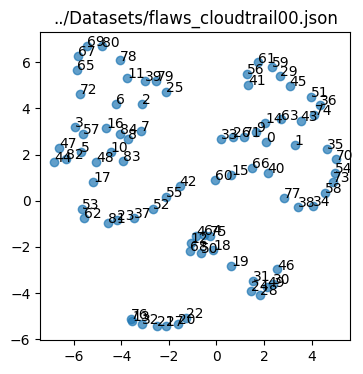

(0, (3.843692, 0.044641864))
(1, (-0.30308205, -1.8815447))
(2, (2.483169, -3.0847132))
(3, (2.8158956, -4.656655))
(4, (1.4217901, -3.3889625))
(5, (0.16295041, -2.6712492))
(6, (2.1301694, 1.0720614))
(7, (3.666603, 1.2473911))
(8, (3.3117776, 2.865268))
(9, (3.632779, 0.5219098))
(10, (1.6690917, -5.1774826))
(11, (2.4480548, -1.2470571))
(12, (5.708957, 5.548345))
(13, (-3.4607236, 4.706435))
(14, (-0.15249182, 3.7350025))
(15, (3.6019368, -1.1840746))
(16, (1.5423002, -6.5061674))
(17, (-3.0137093, 1.6605655))
(18, (8.7354555, 0.034059115))
(19, (4.9498696, 5.694559))
(20, (2.062414, -4.0283875))
(21, (-0.43152806, 3.1765332))
(22, (3.3574526, 3.4783008))
(23, (1.3138894, 7.032112))
(24, (1.3848954, -4.422823))
(25, (-3.6341162, 1.4566114))
(26, (8.677987, -0.62022114))
(27, (6.100294, -4.015292))
(28, (8.29297, 0.43719566))
(29, (3.8988285, 4.905302))
(30, (3.5023022, 2.0330894))
(31, (6.1569314, 5.125191))
(32, (0.8811158, 4.719882))
(33, (1.2960712, 1.3995136))
(34, (-4.9029684

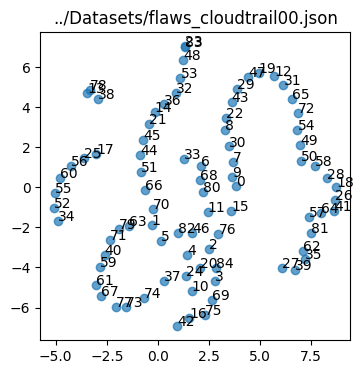

(0, (4.853546, 3.4625325))
(1, (0.37913516, -0.4240633))
(2, (4.5719953, 5.371792))
(3, (3.980168, 3.425874))
(4, (3.9739237, 4.2715745))
(5, (0.8980867, -0.16248108))
(6, (3.5356896, 2.931342))
(7, (1.5137836, -1.7353399))
(8, (5.946894, 3.2459002))
(9, (5.955589, 2.2566056))
(10, (-4.3030295, -2.6778686))
(11, (-7.433066, 5.2711005))
(12, (-3.0786386, 0.16017742))
(13, (1.9102215, 7.1237144))
(14, (-3.0561228, -4.601588))
(15, (-7.501644, 2.1641688))
(16, (2.3391929, 2.487436))
(17, (-4.591169, 2.5613155))
(18, (-1.0216253, -0.389511))
(19, (3.0802746, 1.3017962))
(20, (4.927247, 2.74222))
(21, (-0.14065424, 1.9908792))
(22, (-7.796301, 3.6714056))
(23, (-2.0874057, 6.943988))
(24, (2.1329684, -4.351766))
(25, (1.873598, 0.24408439))
(26, (-2.5765586, -5.0343804))
(27, (-6.3892903, -1.2801806))
(28, (-1.7200801, -5.5968723))
(29, (-4.335368, -3.4864485))
(30, (-7.590514, 4.3945456))
(31, (-3.7835147, -4.104227))
(32, (2.2610583, 4.4441714))
(33, (0.69435406, -5.3546634))
(34, (-0.688

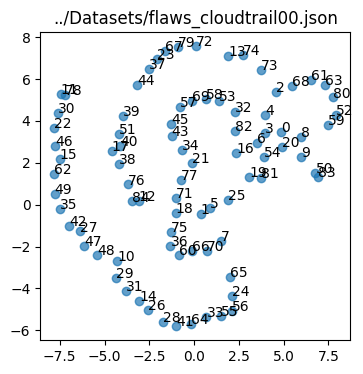

(0, (2.2042232, -0.36576325))
(1, (4.3149495, 0.24316208))
(2, (-0.3471257, 1.3598156))
(3, (3.4162874, 1.1234735))
(4, (-0.9071549, 2.2425258))
(5, (-0.53050345, -1.4973377))
(6, (2.0374334, 10.209369))
(7, (-1.4426719, -7.1389074))
(8, (2.2689893, 2.8925278))
(9, (-0.004241535, 5.4954486))
(10, (-3.3938675, 6.2208776))
(11, (4.1949644, 6.684526))
(12, (-1.5488037, 3.0265121))
(13, (0.96632624, -0.5547114))
(14, (2.9192388, -2.0242074))
(15, (-6.28686, 4.9191914))
(16, (-6.139107, -1.624879))
(17, (3.7402112, 7.4619865))
(18, (6.7818623, -0.4133938))
(19, (-6.6447306, -1.0656589))
(20, (5.1925373, 4.6784186))
(21, (-3.6096475, -5.3437223))
(22, (7.263507, -2.418007))
(23, (1.096277, -2.481815))
(24, (-1.1769145, -1.1201758))
(25, (-1.9257915, -0.5881582))
(26, (1.501295, 4.5080743))
(27, (-2.841542, -5.1754274))
(28, (3.2942524, 8.263055))
(29, (-4.73552, 2.883593))
(30, (-4.6052446, 1.8248268))
(31, (1.6377497, 2.7575345))
(32, (2.6167474, 9.932032))
(33, (4.65058, 5.89729))
(34, (-4

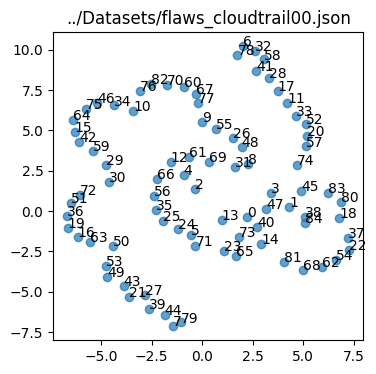

(0, (1.5163884, -0.25073206))
(1, (4.2259345, -1.2712543))
(2, (0.06688733, -0.67713094))
(3, (2.8658504, -0.35451448))
(4, (4.207882, -0.58675337))
(5, (-2.0224793, 6.418669))
(6, (3.3488753, 0.61308074))
(7, (-3.8988974, 0.7361356))
(8, (-2.0689769, -4.838691))
(9, (4.6506495, -4.860652))
(10, (3.6898346, 6.55944))
(11, (-1.4792323, 6.264236))
(12, (-1.8086473, 3.2073522))
(13, (-1.3901604, 2.4849272))
(14, (-1.8667088, -4.208486))
(15, (1.9817513, 8.93491))
(16, (5.320431, 4.9078217))
(17, (-2.6197495, -4.9836016))
(18, (4.023634, -5.359403))
(19, (3.1273215, 8.101467))
(20, (5.3447833, -2.342255))
(21, (-3.8569603, 1.3816035))
(22, (5.6776166, 5.4793067))
(23, (1.1651316, 1.8945318))
(24, (-2.0861044, 2.524972))
(25, (3.4401193, 7.505166))
(26, (9.717837, 0.04427264))
(27, (5.753082, 6.120643))
(28, (9.476756, -0.5398657))
(29, (3.3695362, -5.4776673))
(30, (-1.2617354, 2.9631186))
(31, (2.7956827, -1.708119))
(32, (-1.4401836, -3.8949766))
(33, (-0.92767227, 5.995449))
(34, (2.625

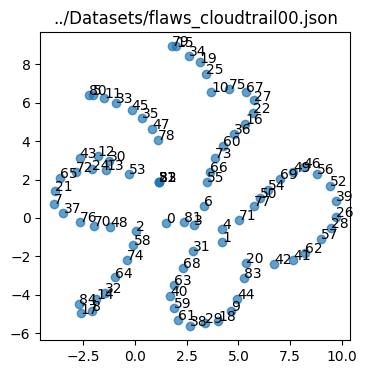

(0, (-2.1725643, -1.3143121))
(1, (-1.5743183, -2.2890713))
(2, (1.1079265, 3.3116333))
(3, (4.318021, 2.8189714))
(4, (3.744692, 3.6295235))
(5, (-2.6150575, -3.9413722))
(6, (-4.9949574, 0.15943426))
(7, (-0.59996957, 6.345746))
(8, (4.0146313, 3.9802997))
(9, (-1.5325947, 1.9237564))
(10, (-1.5849426, 2.2855325))
(11, (2.763809, 7.276353))
(12, (1.3073872, 4.614496))
(13, (0.46098888, 3.168833))
(14, (-4.443339, -0.36454207))
(15, (4.059237, 4.830565))
(16, (0.7838303, 5.407127))
(17, (4.5399346, -0.8205002))
(18, (0.84081936, -3.4901345))
(19, (-4.1449466, -0.85517406))
(20, (-0.58414197, -3.6958513))
(21, (-5.121649, 4.7691197))
(22, (-2.573629, 2.1120248))
(23, (-7.599638, -1.6836675))
(24, (0.12752123, 5.9170365))
(25, (-6.368652, -2.5466099))
(26, (-5.551855, 4.2284174))
(27, (0.22403546, -0.55700934))
(28, (1.1219984, 0.61796165))
(29, (-0.5563726, -3.1252017))
(30, (-3.8721843, -1.5067278))
(31, (-6.553384, -2.1090293))
(32, (-2.321717, 2.4682348))
(33, (1.3200434, 1.42872))


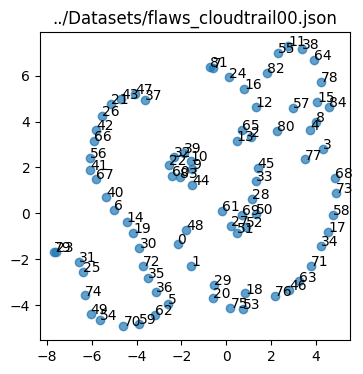

(0, (-2.4957361, -2.6578043))
(1, (-4.636957, 0.27146423))
(2, (-3.6312683, -1.0189302))
(3, (-2.2924447, -3.6884348))
(4, (-7.5242624, 0.61903363))
(5, (-5.94566, 1.1232392))
(6, (-6.4404936, 3.7875977))
(7, (-7.384492, 3.106751))
(8, (-3.6777134, -1.9822748))
(9, (-5.022373, -2.878005))
(10, (-1.0507104, -3.1316621))
(11, (-8.94039, 0.7112339))
(12, (-2.0687842, 2.5723016))
(13, (-1.3796207, 2.6637943))
(14, (-4.1988845, 6.029279))
(15, (-2.6824305, 6.3201976))
(16, (-3.8840148, 6.4404907))
(17, (-10.475779, 2.536498))
(18, (4.4657702, -1.6288462))
(19, (4.232108, -2.3700445))
(20, (-5.456958, 0.5258637))
(21, (2.1542735, 4.202346))
(22, (1.2244359, -3.8932037))
(23, (-6.777106, 4.857716))
(24, (-10.539932, 2.0605288))
(25, (1.4803624, 3.95851))
(26, (-2.1602972, 6.05714))
(27, (0.37945938, -1.2255672))
(28, (-0.064864874, 2.7160408))
(29, (0.3526627, -5.3205085))
(30, (2.0324852, 4.900106))
(31, (-2.4819992, -4.5299826))
(32, (-5.0927987, -0.2892624))
(33, (-2.3560476, 2.4933639))
(

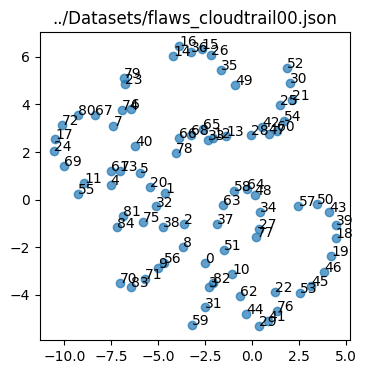

(0, (-1.7087117, -7.1710443))
(1, (-0.43848652, -8.195836))
(2, (-2.4883883, -6.4214387))
(3, (-0.8918021, -9.082721))
(4, (-1.8869008, -6.088631))
(5, (-0.991151, 4.529634))
(6, (-2.4002814, 3.8308573))
(7, (1.3846676, -8.974913))
(8, (0.50704145, -0.22339918))
(9, (-0.5377358, -3.7469857))
(10, (-2.4966404, -9.848511))
(11, (-5.568958, -4.44384))
(12, (1.9139148, 3.256023))
(13, (-5.4878902, -5.0694537))
(14, (-4.0817075, -3.1888468))
(15, (-1.4458698, 4.0948277))
(16, (-4.5463123, -6.9234877))
(17, (-1.6314735, -3.160465))
(18, (2.5126789, -4.594915))
(19, (-2.941543, -0.75543183))
(20, (-3.532661, -0.64992166))
(21, (1.049922, -0.21561211))
(22, (-4.2455583, 3.141682))
(23, (-4.443687, -3.0853424))
(24, (-4.9399805, -6.4838157))
(25, (-2.1037211, 4.431067))
(26, (2.1924958, -4.989093))
(27, (3.7361574, -1.1211833))
(28, (3.8911622, -1.7366132))
(29, (-3.083438, -9.698344))
(30, (-1.7557262, -9.640484))
(31, (-4.1967034, -0.48566762))
(32, (0.14147736, -0.36955726))
(33, (-3.9463916

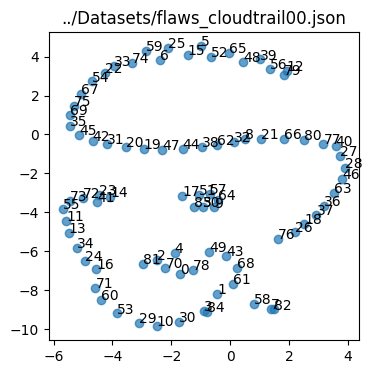

In [39]:
# import seaborn as sns
for node_ids,weighted_node_embeddings_2d in d2_graphs_list:
    alpha = 0.7
    #fig = plt.figure(figsize=(5,5))
    #plt.subplot(1,len(files),num+1)


    plt.figure(figsize=(4, 4))
    plt.scatter(
        weighted_node_embeddings_2d[:, 0],
        weighted_node_embeddings_2d[:, 1],
        #c=node_targets.cat.codes,
        cmap="jet",
        alpha=0.7,
    )
    for i,txt in enumerate(node_ids):
        plt.annotate(i, (weighted_node_embeddings_2d[i][0], weighted_node_embeddings_2d[i][1]))
        print((i, (weighted_node_embeddings_2d[i][0], weighted_node_embeddings_2d[i][1])))
    #plt.axis('off')
    plt.title(file)
    plt.show()

In [40]:
models = []
for _,weighted_node_embeddings_2d in d2_graphs_list:
    clustering = DBSCAN(eps=1.5, min_samples=5).fit(weighted_node_embeddings_2d)
    models.append(clustering)

In [41]:
for clustering in models:
    print(len(clustering.labels_))

85
85
85
85
85
85
85
85


In [42]:
for clustering in models:
    print(clustering)

DBSCAN(eps=1.5)
DBSCAN(eps=1.5)
DBSCAN(eps=1.5)
DBSCAN(eps=1.5)
DBSCAN(eps=1.5)
DBSCAN(eps=1.5)
DBSCAN(eps=1.5)
DBSCAN(eps=1.5)


In [43]:
for clustering in models:
    print(clustering.labels_)

[ 0  0  1  1  2  1  1  1  1  0  1  1  2  3  0  0  1  1  2  2  3  3  3  5
  2  1  0  3  2  0  2  2  3  0  0  0  0  5  0  1  0  0 -1  0  1  0  2  1
  1  2  2  0 -1  1  0 -1  0  1  0  0 -1  0  5  0  2  4  0  4  2  4  0  0
  1  0  0  2  3  0  1  1  4  5  1  1  1]
[-1  0  0  0  0  0 -1 -1  1 -1  0  0  1 -1  2  0  0 -1  3  1  0  2  1 -1
  0 -1  3  3  3  1 -1  1  2 -1 -1  3  2  0 -1  3  0  3  0  1 -1  2  0  1
 -1  3  3 -1 -1 -1 -1 -1 -1  3  3  0 -1  0  3  0  3  1 -1  0 -1  0  0  0
 -1  0  0  0  0  0 -1  0  0  3  0 -1  0]
[ 0 -1  0  0  0 -1  0 -1  0  0 -1 -1 -1 -1 -1 -1  0  2  3  0  0  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  3 -1  2  2  2 -1 -1  1 -1  1 -1 -1
 -1 -1  0  2  4 -1  0 -1 -1 -1 -1  4  3  4 -1  4 -1 -1  3 -1 -1 -1  3 -1
 -1 -1 -1  3  2  1 -1 -1  4  0  0  0 -1]
[ 0  0  1  0  1 -1  2 -1 -1 -1 -1 -1  1  0  0 -1  3 -1 -1  3 -1 -1 -1  0
 -1 -1 -1 -1  2 -1 -1 -1  2 -1 -1 -1  3 -1  0 -1  0  2 -1 -1 -1  0 -1  0
 -1 -1 -1  3 -1 -1 -1 -1 -1 -1  2 -1 -1  1 -1 -1 -1  0  1 -1 -1  1 -1 -1
 